**1) Загрузка всех необходимых библиотек и датасета**

In [ ]:
import os
import requests
import zipfile
import io
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

In [ ]:
url = 'https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/99k-shgJn4yOXg'

response = requests.get(url)
if response.status_code == 200:
    zip_file = io.BytesIO(response.content)
    try:
        with zipfile.ZipFile(zip_file, 'r') as zip_ref:
            zip_ref.extractall('/content/IDC_archive')
        print('Архив успешно скачан и распакован.')
    except zipfile.BadZipFile:
        print('Ошибка: Файл не является архивом ZIP.')
else:
    print('Ошибка при скачивании файла. Пожалуйста, убедитесь, что ссылка верна и доступна.')

Архив успешно скачан и распакован.


**2) Разделение датасета на обучающий, тестовый и валидационные наборы**

In [ ]:
batch_size=256
image_size=(50, 50)

In [ ]:
train_dataset = image_dataset_from_directory('/content/IDC_archive/Train',
                                             subset='training',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 37753 files belonging to 2 classes.
Using 33978 files for training.


In [ ]:
validation_dataset = image_dataset_from_directory('/content/IDC_archive/Train',
                                             subset='validation',
                                             seed=42,
                                             validation_split=0.1,
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 37753 files belonging to 2 classes.
Using 3775 files for validation.


In [ ]:
test_dataset = image_dataset_from_directory('/content/IDC_archive/Test',
                                             batch_size=batch_size,
                                             image_size=image_size)

Found 9892 files belonging to 2 classes.


In [ ]:
class_names = train_dataset.class_names
class_names

['IDC', 'nonIDC']

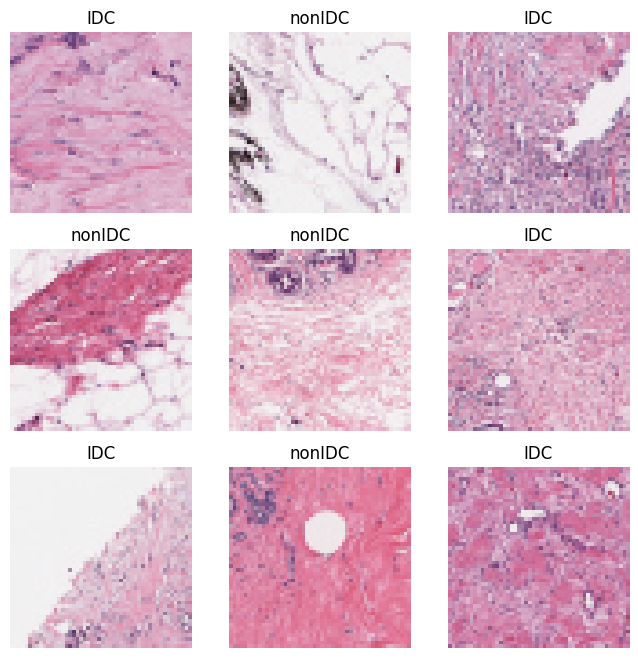

In [ ]:
plt.figure(figsize=(8, 8))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

**3) Создаем нейронную сеть**

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
model = Sequential()
model.add(Conv2D(16, (5, 5), padding='same',
                 input_shape=(50, 50, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (5, 5), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

**4) Обучаем нейронную сеть**

In [ ]:
history = model.fit(train_dataset,
                    validation_data=validation_dataset,
                    epochs=5,
                    verbose=2)

Epoch 1/5
133/133 - 16s - loss: 0.1907 - accuracy: 0.9223 - val_loss: 0.5001 - val_accuracy: 0.8506 - 16s/epoch - 119ms/step
Epoch 2/5
133/133 - 8s - loss: 0.1572 - accuracy: 0.9351 - val_loss: 0.6071 - val_accuracy: 0.8397 - 8s/epoch - 60ms/step
Epoch 3/5
133/133 - 8s - loss: 0.1575 - accuracy: 0.9365 - val_loss: 0.4799 - val_accuracy: 0.8556 - 8s/epoch - 61ms/step
Epoch 4/5
133/133 - 11s - loss: 0.1451 - accuracy: 0.9421 - val_loss: 0.6385 - val_accuracy: 0.8442 - 11s/epoch - 79ms/step
Epoch 5/5
133/133 - 8s - loss: 0.1404 - accuracy: 0.9436 - val_loss: 0.5948 - val_accuracy: 0.8498 - 8s/epoch - 59ms/step


**5) Оценка качества обученной нейронной сети.**

In [ ]:
# Оцениваем качество обучения модели на тестовых данных
scores = model.evaluate(test_dataset, verbose=1)
print("Доля верных ответов на тестовых данных, в процентах:", round(scores[1] * 100, 4))

39/39 [==============================] - 2s 37ms/step - loss: 0.9510 - accuracy: 0.8203
Доля верных ответов на тестовых данных, в процентах: 82.0259


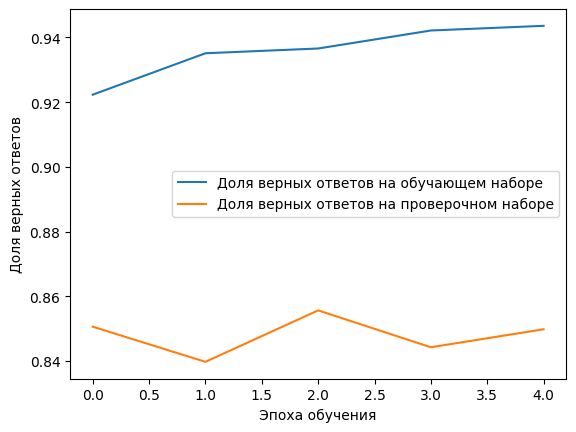

In [ ]:
plt.plot(history.history['accuracy'],
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'],
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

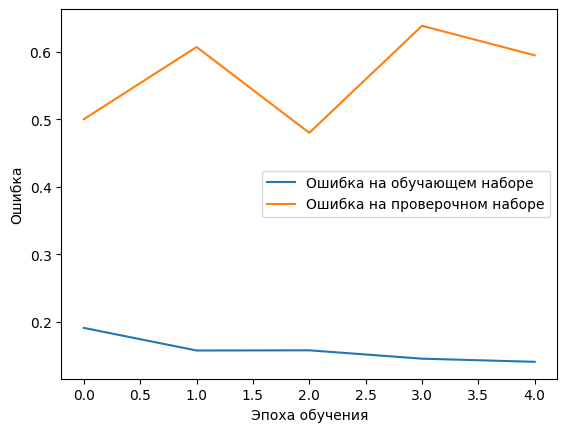

In [ ]:
plt.plot(history.history['loss'],
         label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Ошибка')
plt.legend()
plt.show()